<a href="https://colab.research.google.com/github/DeguShi/AI-notebooks/blob/main/A_start_faltando_documentacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 1:



In [1]:
import pandas as pd
import numpy as np

try: import folium
except:
    !pip install folium
from folium.plugins import MarkerCluster

from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
import heapq
import time
import pickle
from sklearn.metrics.pairwise import haversine_distances
from IPython.display import display
import os


if not os.path.exists('alagamentos.xlsx'): # baixando os dados só na primeira run, achei melhor assim
    !gdown 1K0tu3E-kcu7ikQcyNnKixjCY8vSjvxgl -O alagamentos.xlsx

print("Bibliotecas e dataset importados!")

# Carrego todo dadaset primeiro e separo os dados em um jeito que fica mais facil extrair as informações depois

df_base = pd.read_excel('alagamentos.xlsx')
df_base[['lat', 'lon']] = df_base['localidade'].str.split(",", expand=True).astype(float)
df_base['cidade'] = df_base['descricao']


df_base

Downloading...
From: https://drive.google.com/uc?id=1K0tu3E-kcu7ikQcyNnKixjCY8vSjvxgl
To: /content/alagamentos.xlsx
100% 381k/381k [00:00<00:00, 80.9MB/s]
Bibliotecas e dataset importados!


,descricao,localidade,lat,lon,cidade
0,Chuvas deixam cidade de SP em estado de atençã...,"-23.567387,-46.570383",-23.567387,-46.570383,Chuvas deixam cidade de SP em estado de atençã...
1,Chuva em SP deixa linha de trem e trecho de ro...,"-23.567387,-46.570383",-23.567387,-46.570383,Chuva em SP deixa linha de trem e trecho de ro...
2,Cidade de São Paulo entra em estado de atenção...,"-23.567387,-46.570383",-23.567387,-46.570383,Cidade de São Paulo entra em estado de atenção...
3,"Chuva em SP causa queda de árvores, alagamento...","-23.567387,-46.570383",-23.567387,-46.570383,"Chuva em SP causa queda de árvores, alagamento..."
4,São Paulo registra 18ª morte por causa das chu...,"-23.567387,-46.570383",-23.567387,-46.570383,São Paulo registra 18ª morte por causa das chu...
...,...,...,...,...,...
11939,Chuva forte e ventos intensos trazem alerta ao...,"-21.210591,-41.886203",-21.210591,-41.886203,Chuva forte e ventos intensos trazem alerta ao...
11940,Afetados por chuvas receberão auxílio nas próx...,"-21.210591,-41.886203",-21.210591,-41.886203,Afetados por chuvas receberão auxílio nas próx...
11941,Fortes chuvas causam alagamentos em Bom Jesus ...,"-21.210591,-41.886203",-21.210591,-41.886203,Fortes chuvas causam alagamentos em Bom Jesus ...
11942,BR-101 é interditada nos dois sentidos em Camp...,"-21.210591,-41.886203",-21.210591,-41.886203,BR-101 é interditada nos dois sentidos em Camp...


# Preciso add exemplicação para a haver depois



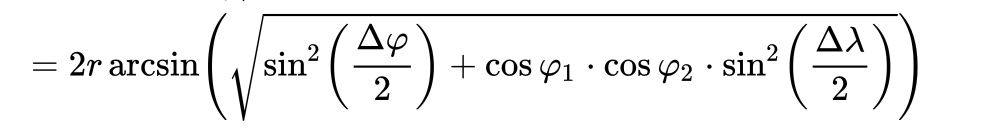

In [2]:
# Funcao haversine para calcular a distancia entre cidades

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1_rad = radians(lat1)
    lat2_rad = radians(lat2)
    a = sin(dLat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dLon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [3]:
# Como existem muitas notícias sobre uma mesma coord, vou dar um groupby e trabalhar só informações únicas

df_unicos = df_base.groupby(['lat', 'lon'], as_index=False).first()

# Dados para facilitar testagem entre samples e controle de geração:

AUTONOMIA = 750.0 # distancia que o drone consegue viajar por trecho
RANDOM_SEED = 42
SAMPLE_SIZE = 10000 # eu segui esse tamanho porque estava inicialmente assim no .ipynb da descrição da atividade

unique_sample_size = min(SAMPLE_SIZE, len(df_unicos))
df = df_unicos.sample(unique_sample_size, random_state=RANDOM_SEED).reset_index(drop=True)

# Aqui eu suponho que tenha um jeito inteligente para fazer isso, mas eu optei por fazer esse dicionário manualmente:

capitais_coords_map = {
    'Aracaju':        (-10.907216, -37.048213), 'Belém':          (-1.459845,  -48.487826),
    'Belo Horizonte': (-19.937524, -43.926453), 'Boa Vista':      (2.816682,   -60.670533),
    'Brasília':       (-15.779720, -47.929720), 'Campo Grande':   (-20.448610, -54.629720),
    'Cuiabá':         (-15.598890, -56.094720), 'Curitiba':       (-25.429720, -49.271940),
    'Florianópolis':  (-26.304518,-48.849409), 'Fortaleza':      (-3.731940,  -38.526670),
    'Goiânia':        (-16.680000, -49.255000), 'João Pessoa':    (-7.119440,  -34.863060),
    'Macapá':         (0.038890,   -51.066390), 'Maceió':         (-9.665830,  -35.735280),
    'Manaus':         (-3.118890,  -60.025000), 'Natal':          (-5.794440,  -35.209440),
    'Palmas':         (-10.167500, -48.331670), 'Porto Alegre':   (-30.033060, -51.230000),
    'Porto Velho':    (-8.761940,  -63.903890), 'Recife':         (-8.054170,  -34.881390),
    'Rio Branco':     (-9.974720,  -67.810000), 'Rio de Janeiro': (-22.871251,-43.775041),
    'Salvador':       (-12.971110, -38.510830), 'São Luís':       (-2.529720,  -44.302780),
    'São Paulo':      (-23.550520, -46.633308), 'Teresina':       (-5.090000,  -42.810000),
    'Vitória':        (-20.319440, -40.337780)
}

# Agora eu defino quais cidades unicas são capitais, isso é relavante tanto para o calculo de rota quanto para representação grafica

nome_cap_para_id = {}
df['is_cap'] = False


cap_dic = pd.DataFrame(capitais_coords_map.items(), columns=['NomeCap', 'Coords'])
cap_dic[['cap_lat', 'cap_lon']] = pd.DataFrame(cap_dic['Coords'].tolist(), index=cap_dic.index)


# agora eu mapeio os dados do df de modo a categorizar as capitais com o dicionário que fiz acima:

for index, cap_linha in cap_dic.iterrows():
  distancias = df.apply(lambda linha: haversine(cap_linha['cap_lat'], cap_linha['cap_lon'], linha['lat'], linha['lon']), axis=1)
  index_no_df = distancias.idxmin()
  if index_no_df not in nome_cap_para_id.values() and distancias.min() <10:
    nome_cap_para_id[cap_linha['NomeCap']] = index_no_df
    df.loc[index_no_df, 'is_cap'] = True
    df.loc[index_no_df, 'cidade'] = cap_linha['NomeCap']

# Só informa os dados classificados até então

print(f"\n{len(df)} cidades unicas (Sample {unique_sample_size}, Seed {RANDOM_SEED}).")
print(f"{len(nome_cap_para_id)} capitais identificadas na amostra e mapeadas:")
print(nome_cap_para_id)

# Agora crio um set para as capitais (para verificar dados mais rapido) e um pkl para cache de distacias min até um capital depois

id_set_cap = set(nome_cap_para_id.values())

dist_min_cap_file = f'dist_min_capital_s{len(df)}_r{RANDOM_SEED}.pkl'
if os.path.exists(dist_min_cap_file): os.remove(dist_min_cap_file)

df


318 cidades unicas (Sample 318, Seed 42).
26 capitais identificadas na amostra e mapeadas:
{'Aracaju': 296, 'Belém': 68, 'Belo Horizonte': 36, 'Boa Vista': 311, 'Brasília': 257, 'Cuiabá': 309, 'Curitiba': 144, 'Florianópolis': 167, 'Fortaleza': 87, 'Goiânia': 142, 'João Pessoa': 146, 'Macapá': 291, 'Maceió': 175, 'Manaus': 34, 'Natal': 164, 'Palmas': 73, 'Porto Alegre': 224, 'Porto Velho': 194, 'Recife': 297, 'Rio Branco': 180, 'Rio de Janeiro': 267, 'Salvador': 178, 'São Luís': 75, 'São Paulo': 81, 'Teresina': 240, 'Vitória': 32}


,lat,lon,descricao,localidade,cidade,is_cap
0,-23.468506,-46.531084,Concessionária de carros de luxo fica completa...,"-23.468506,-46.531084",Concessionária de carros de luxo fica completa...,False
1,-5.352606,-49.142025,Enchentes em 3 cidades do Pará deixam famílias...,"-5.352606,-49.142025",Enchentes em 3 cidades do Pará deixam famílias...,False
2,-26.991819,-48.634617,Veja imagens dos alagamentos em Balneário Camb...,"-26.991819,-48.634617",Veja imagens dos alagamentos em Balneário Camb...,False
3,-7.828372,-34.910583,Prefeita de Igarassu fala sobre situação do mu...,"-7.828372,-34.910583",Prefeita de Igarassu fala sobre situação do mu...,False
4,-29.759823,-57.081825,Prejuízos e alagamento: funcionários de instit...,"-29.759823,-57.081825",Prejuízos e alagamento: funcionários de instit...,False
...,...,...,...,...,...,...
313,-19.224346,-42.605661,Abrigos provisórios para moradores de áreas de...,"-19.224346,-42.605661",Abrigos provisórios para moradores de áreas de...,False
314,-23.499323,-47.457853,FOTOS: Chuva causa alagamentos e transtornos e...,"-23.499323,-47.457853",FOTOS: Chuva causa alagamentos e transtornos e...,False
315,-22.858395,-47.221097,Chuva intensa em Hortolândia causa alagamentos...,"-22.858395,-47.221097",Chuva intensa em Hortolândia causa alagamentos...,False
316,-6.214964,-36.688662,"Temporal deixa Baixada Santista, SP, debaixo d...","-6.214964,-36.688662","Temporal deixa Baixada Santista, SP, debaixo d...",False


# Grafo

In [4]:
# Agora eu vou começar a preparar os dados para criar um grafo a partir do df

coords_rad = np.radians(df[['lat', 'lon']].values)
matriz_dist_km = haversine_distances(coords_rad, coords_rad)*6371.0

print("Matriz de distâncias pronta.")



graph = {i: [] for i in df.index}

indices_i, indices_j = np.where((matriz_dist_km <= AUTONOMIA) & (matriz_dist_km > 0))

for i, j in zip(indices_i, indices_j):
    dist = matriz_dist_km[i,j]
    graph[df.index[i]].append((df.index[j], dist))

print("Grafo pronto.\n")

# Isso vai me ajudar para quando eu for montar meu  "A*" mais a diante :D

grau_nos = {node_idx: len(v) for node_idx, v in graph.items()}

for i in df.index:
  if i not in graph:
    grau_nos[i] = 0

print("Grau dos nos calculados\n")

Matriz de distâncias pronta.
Grafo pronto.

Grau dos nos calculados



In [5]:
# estava achando estranho a dist de RJ e FL ser curta suficiente para existir uma aresta entre elas


idx_rj_df = nome_cap_para_id.get('Rio de Janeiro')
idx_flo_df = nome_cap_para_id.get('Florianópolis')

if idx_rj_df is not None and idx_flo_df is not None:
    print(f"Índice de RJ no df: {idx_rj_df}")
    print(f"Índice de FL no df: {idx_flo_df}")
else:
    print("RJ ou FLO não presntes")



if idx_rj_df is not None and idx_flo_df is not None:
    coords_rj_no_df = df.loc[idx_rj_df, ['lat', 'lon']]
    coords_flo_no_df = df.loc[idx_flo_df, ['lat', 'lon']]
    print(f"Coordenadas de RJ no df: lat={coords_rj_no_df['lat']}, lon={coords_rj_no_df['lon']}")
    print(f"Coordenadas de FL no df: lat={coords_flo_no_df['lat']}, lon={coords_flo_no_df['lon']}")


if idx_rj_df is not None and idx_flo_df is not None:
  distancia_na_matriz = matriz_dist_km[idx_rj_df, idx_flo_df]
  print(f"dist rj-fl direto da matriz_dist_km: {distancia_na_matriz:.10f} km")


if idx_rj_df is not None and idx_flo_df is not None:
  # Com sua função haversine
  dist_manual_com_coords_df = haversine(coords_rj_no_df['lat'], coords_rj_no_df['lon'],
                                        coords_flo_no_df['lat'], coords_flo_no_df['lon'])
  print(f"dist com a minha haversine: {dist_manual_com_coords_df:.10f} km")

  # Com sklearn
  coords_rj_df_rad = np.radians(np.array([[coords_rj_no_df['lat'], coords_rj_no_df['lon']]]))
  coords_flo_df_rad = np.radians(np.array([[coords_flo_no_df['lat'], coords_flo_no_df['lon']]]))
  dist_sklearn_com_coords_df = haversine_distances(coords_rj_df_rad, coords_flo_df_rad)[0][0] * 6371.0
  print(f"dist com a haversine_dist printa da sk: {dist_sklearn_com_coords_df:.10f} km")

Índice de RJ no df: 267
Índice de FL no df: 167
Coordenadas de RJ no df: lat=-22.871251, lon=-43.775041
Coordenadas de FL no df: lat=-26.304518, lon=-48.849409
dist rj-fl direto da matriz_dist_km: 639.4026807773 km
dist com a minha haversine: 639.4026807773 km
dist com a haversine_dist printa da sk: 639.4026807773 km


In [6]:
# Algumas definições para calcular a profundidade de busca:

# Eu defini meio que arbitrariamente durante meus testes o que eu considerava uma celula em regiao densa e uma celula em regiao esparsa
# isso é fundamental para eu conseguir variar minha profundidade de busca de maneira otimizada
# para cada nó depois. As cidades escolhidas foram SP e POA porque durante minhas testagens, eu achava 211 cidades na rota partindo de SP
# e somente 190 cidades partindo de POA, isso não fazia sentido para mim, pois se eu chego em POA a partir de SP e encontro 211, o contrário
# deveria ser verdade também. Eu conclui que o problema provavelmente é o fato que a profundidade alta no final da busca consume muito poder
# computacional e memória em geral, pois eu fico guardando muita informação nas minhas iteracoes, para resolver isso eu testei POA com profundidade
# maior e cheguei nas 211 cidades que eu queria, isso abriu meus olhos para uma maneira de otimizar a busca.

idx_sp = nome_cap_para_id.get('São Paulo', -1)
idx_poa = nome_cap_para_id.get('Porto Alegre', -1)

grau_sp = grau_nos.get(idx_sp, -1) if idx_sp != -1 else -1
grau_poa = grau_nos.get(idx_poa, -1) if idx_poa != -1 else -1

# Valores que obtive enquanto testava profundidades fixas manualmente

DEPTH_SP = 5
DEPTH_POA = 20

MIN_OPT_DEPTH = 3
MAX_OPT_DEPTH = 30


print("Referências para profundidade otimizada:")
if grau_sp != -1: print(f"São Paulo: Grau = {grau_sp}, prof: {DEPTH_SP}")
else: print(f"São Paulo não encontrada para referência de grau.")
if grau_poa != -1: print(f"Porto Alegre: Grau = {grau_poa}, prof: {DEPTH_POA}")
else: print(f"Porto Alegre não encontrada para referência de grau.")

Referências para profundidade otimizada:
São Paulo: Grau = 175, prof: 5
Porto Alegre: Grau = 48, prof: 20


In [7]:
# Funcao para calculo da profundidade de fato:

def calcular_profundidade_opt(cur_grau, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp):

  # Se o sample tiver algum problema com as referencias que escolhi:

  if g_sp == -1 or g_poa ==  -1 or g_sp == g_poa:
    return (min_dp+max_dp)//2 # usa uma média para trabalhar

  # A ideia em si é simples, eu queria que um no em uma região de alta densidade tivesse profundidade baixa
  # e o contrário também fosse verdade. Sendo assim:

  m = (dp_poa-dp_sp)/(g_poa-g_sp)

  c = dp_sp-m*g_sp

  dp_calculada = m*cur_grau+c

  dp_final = int(round(np.clip(dp_calculada, min_dp, max_dp)))

  return dp_final


print("Calculo de graus e profundidade otimizada prontos.")

Calculo de graus e profundidade otimizada prontos.


In [8]:
# Agora eu faço as funcoes que vou usar para pre calcular os menores caminhos:

def dijkstra_menor_caminho(g_dic, start_id):
  id_nos_df = list(df.index)
  open_set = [(0, start_id)]
  heapq.heapify(open_set)

  g_score = {idx: float('inf') for idx in id_nos_df}

  if start_id in g_score: g_score[start_id] = 0
  else: return {idx: float('inf') for idx in id_nos_df}

  while open_set:
    cur_g, cur = heapq.heappop(open_set)

    if cur_g > g_score.get(cur, float('inf')): continue

    for v, d in g_dic.get(cur, []):
      if v not in g_score: continue
      temp_g = cur_g + d
      if temp_g < g_score[v]:
        g_score[v] = temp_g
        heapq.heappush(open_set, (temp_g, v))
  return g_score

print("Dijkstra feito.")



def pre_calcular_dist_to_capital(g_dic, id_cap_p_set, nos_df, filename):
  print("Pré calculando distancias para capitais...")

  dist_todas_cap = {}
  for id_cap in tqdm(id_cap_p_set, desc="calculando dijkstra para as cap"):
    dist_da_cap = dijkstra_menor_caminho(g_dic, id_cap)
    dist_todas_cap[id_cap] = dist_da_cap

  dist_min_cap_dic = {idx: float('inf') for idx in nos_df.index}
  for id_no in tqdm(nos_df.index, desc="calculando menor dist"):
    min_dist = float('inf')


    for id_cap in id_cap_p_set:
      dist = dist_todas_cap[id_cap].get(id_no, float('inf'))
      if dist < min_dist: min_dist = dist

    dist_min_cap_dic[id_no] = min_dist

  # salva essas distancias durante a exec para não precisar repetir no mesmo sample
  with open(filename, 'wb')as f: pickle.dump(dist_min_cap_dic, f)
  print(f"Funcao de pre calculo pronta e salva em '{filename}'.")

  return dist_min_cap_dic


#salva tudo
dist_min_cap_filename_global = f'dist_min_capital_s{len(df)}_r{RANDOM_SEED}.pkl'


if not id_set_cap:
    print("Deu algum erro na classificacao de cap, no id_set não tem nada.")
    dist_min_cap = {idx: float('inf') for idx in df.index}
else:
    try:
        with open(dist_min_cap_filename_global, 'rb') as f: dist_min_cap = pickle.load(f)
        if len(dist_min_cap) != len(df):
             dist_min_cap = pre_calcular_dist_to_capital(graph, id_set_cap, df, dist_min_cap_filename_global)
    except FileNotFoundError:
        dist_min_cap = pre_calcular_dist_to_capital(graph, id_set_cap, df, dist_min_cap_filename_global)
print("Distâncias mínimas às capitais prontas.")

Dijkstra feito.
Pré calculando distancias para capitais...


calculando menor dist: 100%|██████████| 318/318 [00:00<00:00, 60811.96it/s]

Funcao de pre calculo pronta e salva em 'dist_min_capital_s318_r42.pkl'.
Distâncias mínimas às capitais prontas.


# Heurística para maximizar

In [9]:
R_SCAN = 100

# pre computa para cada cidade (nao cap), uma lista de outras cidades dentro do raio informado na variavel R_SCAN
# vai servir para informar a heuristica dos clusters de cidades proximas

def pre_calculate_local_density_info(df_nodes, R_scan_param, id_cap_set_param):

    print(f"Pré-calculando densidade local com raio de {R_scan_param} km...")
    local_density_map = {}

    # Filtra apenas os índices das cidades não-capitais
    id_cities_nao_cap = [idx for idx in df_nodes.index if idx not in id_cap_set_param]
    # Converte as coordenadas das cidades não-capitais para radianos para haversine_distances
    rad_cities_nao_cap = np.radians(df_nodes.loc[id_cities_nao_cap, ['lat', 'lon']].values)

    if len(id_cities_nao_cap) > 0:
        # Calcula a matriz de distâncias entre TODAS as cidades não-capitais
        dist_nao_cap = haversine_distances(rad_cities_nao_cap, rad_cities_nao_cap) * 6371.0

        # Mapeia o índice original do DataFrame para a posição na lista `id_cities_nao_cap`
        original_idx_to_pos = {idx: i for i, idx in enumerate(id_cities_nao_cap)}

        for i, no_id_i in tqdm(enumerate(id_cities_nao_cap), total=len(id_cities_nao_cap), desc="Calculando vizinhos locais"):
            nos_perto = []
            # Itera sobre todas as outras cidades não-capitais
            for j, no_id_j in enumerate(id_cities_nao_cap):
                if i != j: # Garante que não estamos comparando a cidade consigo mesma
                    # Usa a matriz de distâncias pré-calculada
                    dist = dist_nao_cap[i, j]
                    if dist <= R_scan_param:
                        nos_perto.append(no_id_j)
            local_density_map[no_id_i] = nos_perto
    else:
        print("Nenhuma cidade não-capital encontrada para análise de densidade local.")

    print("Densidade local pré-calculada.")
    return local_density_map

# Chame a função para popular o mapa de densidade local
local_density_map_global = pre_calculate_local_density_info(df, R_SCAN, id_set_cap)

Pré-calculando densidade local com raio de 100 km...


Calculando vizinhos locais: 100%|██████████| 292/292 [00:00<00:00, 3640.37it/s]

Densidade local pré-calculada.


Eu tive que mudar bastante essa função conforme eu testava, pois não é intuitivo como usar tantos parâmetros e saber que o resultado disso realmente
importa.

Em geral essa heurística busca estimar a quantidade de cidades que o drone ainda poderia visitar (não capitais) a partir de cur_city e cur_v_fset.

O jeito que essa heurística funciona é uma mescla entre o uso de um algoritmo ganhancioso e registro de memoria em "caches" (para otimização)

In [10]:
cache_heu = {}
DENSITY_WEIGHT = 7.0

def max_path_heu(cur_city, cur_v_set, gf_map, dist_min_cap_dic, max_auto_val, no_df_dic, max_dp_calculada, local_density_map):
    cache_key = (cur_city, cur_v_set)
    if cache_key in cache_heu:
        return cache_heu[cache_key]

    h_value = 0
    sim_cur = cur_city
    sim_v_set = set(cur_v_set)
    sim_cur_dp = 0

    while sim_cur_dp < max_dp_calculada:
        temp_candidates = []

        for v, d in gf_map.get(sim_cur, []):
            if v not in sim_v_set and not no_df_dic.loc[v, 'is_cap']:
                potential_cities_nearby = 0
                if v in local_density_map:
                        for nearby_node_id in local_density_map.get(v, []):
                                if nearby_node_id not in sim_v_set:
                                        potential_cities_nearby += 1

                combined_score = d - (DENSITY_WEIGHT * potential_cities_nearby)
                temp_candidates.append((combined_score, d, v))

        if not temp_candidates:
            break

        temp_candidates.sort()
        best_score, best_dist, best_v = temp_candidates[0]

        sim_cur = best_v
        sim_v_set.add(best_v)
        h_value += 1
        sim_cur_dp += 1

    cache_heu[cache_key] = h_value
    return h_value

print("Funcao heuristica com cache e densidade adaptada pronta para uso.")


Funcao heuristica com cache e densidade adaptada pronta para uso.


#A* de fato:

In [14]:
def a_star_max_heu(gf_map, start_no_id, no_cap_set, no_df_map, max_auto_val, dist_min_cap_map, graus_map, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp, max_time_sim=300, max_it_sem_achar_nada=30000, local_density_map=None):
    start_time = time.time()
    cache_heu.clear()

    def heu_aux(id_city,v_set):
        cur_grau = graus_map.get(id_city, 0)
        dp_nessa_call = calcular_profundidade_opt(cur_grau, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp)
        return max_path_heu(id_city, v_set, gf_map, dist_min_cap_map, max_auto_val, no_df_map, max_dp_calculada=dp_nessa_call, local_density_map=local_density_map)

    start_comb = max_auto_val
    start_v_fset = frozenset([start_no_id])
    start_g = len(start_v_fset)

    start_no_grau = graus_map.get(start_no_id, 0)
    start_no_dp = calcular_profundidade_opt(start_no_grau, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp)

    start_h = max_path_heu(start_no_id, start_v_fset, gf_map, dist_min_cap_map,max_auto_val, no_df_map, max_dp_calculada=start_no_dp, local_density_map=local_density_map)
    start_f = start_g + start_h

    no_cnt = 0
    open_set = []

    dado_ini_no = (start_no_id, start_comb, start_v_fset, [start_no_id], [start_comb])
    heapq.heappush(open_set, (-start_f, -start_g, no_cnt, dado_ini_no))


    pontos_conhecidos = {}
    pontos_conhecidos[(start_no_id, start_v_fset)] = start_comb

    best_g_detodos = 0
    best_path_detodos = []
    best_comb_detodos = []

    iter_count = 0
    it_sem_achar_nada = 0
    parada_por_limite = False

    print("Iniciando busca A*...")
    print(f"==> Profundidade para nó inicial ({no_df_map.loc[start_no_id, 'cidade']}, grau {start_no_grau}): {start_no_dp}")
    print("------ Número de cidades visitadas na melhor rota até agora: ------")

    while open_set:
        current_time_exec = time.time()
        if current_time_exec - start_time > max_time_sim:
            print(f"Tempo limite de {max_time_sim}s atingido.")
            parada_por_limite = True
            break

        iter_count += 1
        it_sem_achar_nada += 1

        if it_sem_achar_nada >= max_it_sem_achar_nada:
            print(f"\nCritério de parada alcançado: nenhuma rota nova foi encontrada por {max_it_sem_achar_nada} iterações.")
            parada_por_limite = True
            break

        if iter_count % 10000 == 0:
            cache_size = len(cache_heu)
            # Obter cur_city do último melhor estado ou do início para o log
            log_cur_city_idx = best_path_detodos[-1] if best_path_detodos else start_no_id
            cur_city_gr = graus_map.get(log_cur_city_idx, 0)
            call_dp = calcular_profundidade_opt(cur_city_gr, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp)
            print(f"Iter: {iter_count}, Melhor rota: {best_g_detodos},"
                  f"T: {current_time_exec - start_time:.1f}s, "
                  f"Profundidade para nó g={cur_city_gr} (último melhor): {call_dp}, "
                  f"Iters s/ melhora: {it_sem_achar_nada}")

        try:
            _, neg_g_score, _, current_node_tuple = heapq.heappop(open_set)
            # Desempacota o estado, incluindo a lista de níveis de combustível
            (cur_city, cur_comb_at_arrival, cur_v, cur_path_no, cur_path_comb) = current_node_tuple
        except IndexError:
            print("Fila vazia.")
            break

        cur_g_val = -neg_g_score # Número de cidades visitadas

        if cur_g_val > best_g_detodos:
            best_g_detodos = cur_g_val
            best_path_detodos = cur_path_no
            best_comb_detodos = cur_path_comb # Salva a lista de comb por nó

            cur_city_for_log_grau = graus_map.get(cur_city,0)
            adaptive_depth_for_log = calcular_profundidade_opt(cur_city_for_log_grau, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp)

            print(f"     | {best_g_detodos:<3} cidades    ===>    "
                  f"[Grau: {cur_city_for_log_grau}, Profundidade: ~{adaptive_depth_for_log}] |")
            it_sem_achar_nada = 0
        fuel_after_refuel = max_auto_val
        if cur_city in no_cap_set and cur_comb_at_arrival < fuel_after_refuel :


            if pontos_conhecidos.get((cur_city, cur_v), -1) < fuel_after_refuel: # Se o comb para sair deste estado era menor que o tanque cheio.
                pontos_conhecidos[(cur_city, cur_v)] = fuel_after_refuel # Agora temos tanque cheio para sair.
                h_val_refuel = heu_aux(cur_city, cur_v)
                f_score_refuel = cur_g_val + h_val_refuel # g_val não muda, só o potencial futuro e o comb.
                no_cnt +=1
                refueled_node_data = (cur_city, fuel_after_refuel, cur_v, cur_path_no, cur_path_comb)
                heapq.heappush(open_set, (-f_score_refuel, -cur_g_val, no_cnt, refueled_node_data))

        for v_city, dist_to_v in gf_map.get(cur_city, []):
            if cur_comb_at_arrival >= dist_to_v:
                comb_no_v = cur_comb_at_arrival - dist_to_v

                dist_to_nearest_cap_from_neighbor = dist_min_cap_map.get(v_city, float('inf'))
                if comb_no_v < dist_to_nearest_cap_from_neighbor:
                    continue

                temp_v_fset = cur_v | {v_city}
                temp_g_val = len(temp_v_fset)
                prev_best_comb_em_v = pontos_conhecidos.get((v_city, temp_v_fset), -1)

                if prev_best_comb_em_v >= comb_no_v:
                    continue

                pontos_conhecidos[(v_city, temp_v_fset)] = comb_no_v

                novo_no_path = cur_path_no + [v_city]
                novo_no_comb = cur_path_comb + [comb_no_v]

                heu_val_p_vizinho = heu_aux(v_city, temp_v_fset)
                f_score_v = temp_g_val + heu_val_p_vizinho

                no_cnt += 1
                neighbor_node_data = (v_city, comb_no_v, temp_v_fset, novo_no_path, novo_no_comb)
                heapq.heappush(open_set, (-f_score_v, -temp_g_val, no_cnt, neighbor_node_data))

    if parada_por_limite and best_path_detodos:
        ultima_cidade_id = best_path_detodos[-1]

        print("-" * 50)
        print("Verificando rota final devido à parada por limite...")

        if ultima_cidade_id in no_cap_set:
            print("OK: A última cidade da melhor rota já é uma capital.")
        else:
            print(f"Aviso: A última cidade ({no_df_map.loc[ultima_cidade_id, 'cidade']}) não é uma capital.")
            print("Calculando rota de retorno para a capital vizinha mais próxima...")

            combustivel_na_ultima_cidade = best_comb_detodos[-1]
            capital_mais_proxima_id = None
            menor_distancia_para_capital = float('inf')

            # Procura a capital mais próxima entre os vizinhos diretos
            for vizinho_id, dist in gf_map.get(ultima_cidade_id, []):
                if vizinho_id in no_cap_set and dist < menor_distancia_para_capital:
                    menor_distancia_para_capital = dist
                    capital_mais_proxima_id = vizinho_id

            if capital_mais_proxima_id and combustivel_na_ultima_cidade >= menor_distancia_para_capital:
                # Adiciona o trecho final para a capital
                best_path_detodos.append(capital_mais_proxima_id)
                combustivel_final = combustivel_na_ultima_cidade - menor_distancia_para_capital
                best_comb_detodos.append(combustivel_final)

                # Atualiza a contagem de cidades visitadas (usando set para não contar duplicado)
                best_g_detodos = len(set(best_path_detodos))

                print(f"SUCESSO: Rota estendida para a capital '{no_df_map.loc[capital_mais_proxima_id, 'cidade']}'.")
                print(f"Combustível final: {combustivel_final:.2f}L")
            else:
                print("FALHA: Não foi possível estender a rota (sem combustível ou nenhuma capital vizinha encontrada).")
        print("-" * 50)


    return best_path_detodos, best_g_detodos, best_comb_detodos


In [15]:
capital_de_partida_nome = 'São Paulo'
TEMPO_LIMITE_GLOBAL_A_STAR = 300

rota_global_final = []
cidades_global_final_count = 0
fuel_levels_raw_from_astar = []

if capital_de_partida_nome not in nome_cap_para_id:
    print(f"Erro: Capital '{capital_de_partida_nome}' não no mapeamento 'nome_cap_para_id'.")
elif 'dist_min_cap' not in locals():
    print("Erro: 'dist_min_cap' não calculado.")
elif idx_sp == -1 or idx_poa == -1 or grau_sp == -1 or grau_poa == -1:
    print("Erro: São Paulo ou Porto Alegre não encontrados para referências de grau/profundidade.")
else:
    start_node_idx_global = nome_cap_para_id[capital_de_partida_nome]

    print(f"\n------Iniciando busca A* a partir de: {capital_de_partida_nome}")
    print(f"------Tempo limite: {TEMPO_LIMITE_GLOBAL_A_STAR}s.")
    print(f"------Referências de profundidade: SP (grau {grau_sp}, target {DEPTH_SP}), POA (grau {grau_poa}, target {DEPTH_POA})")
    print(f"------Limites de profundidade da heurística: min={MIN_OPT_DEPTH}, max={MAX_OPT_DEPTH}")

    rota_global_final, cidades_global_final_count, fuel_levels_raw_from_astar = a_star_max_heu(
        gf_map=graph,
        start_no_id=start_node_idx_global,
        no_cap_set=id_set_cap,
        no_df_map=df,
        max_auto_val=AUTONOMIA,
        dist_min_cap_map=dist_min_cap,
        graus_map=grau_nos,
        g_sp=grau_sp, dp_sp=DEPTH_SP,
        g_poa=grau_poa, dp_poa=DEPTH_POA,
        min_dp=MIN_OPT_DEPTH, max_dp=MAX_OPT_DEPTH,
        max_time_sim=TEMPO_LIMITE_GLOBAL_A_STAR,
        max_it_sem_achar_nada=30000,
        local_density_map=local_density_map_global
    )

print("\n---Busca A* Concluída ---")
print(f"Capital Inicial: {capital_de_partida_nome}")
print(f"Número Total de Cidades ÚNICAS Visitadas (g*): {cidades_global_final_count}")

distancia_total_missao = 0
if rota_global_final and len(rota_global_final) > 1:
    for i in range(len(rota_global_final)-1):
        idx1, idx2 = rota_global_final[i], rota_global_final[i+1]
        edge_found = False
        dist_edge = 0
        if idx1 in graph:
            for neighbor, dist_val in graph.get(idx1, []):
                if neighbor == idx2:
                    dist_edge = dist_val
                    edge_found = True
                    break
        if edge_found:
            distancia_total_missao += dist_edge
        elif idx1 in df.index and idx2 in df.index:
             distancia_total_missao += haversine(df.loc[idx1,'lat'], df.loc[idx1,'lon'], df.loc[idx2,'lat'], df.loc[idx2,'lon'])

print(f"Distância Total Percorrida na Missão: {distancia_total_missao:.2f} km")

indices_de_parada_em_capital_na_rota = []
if rota_global_final:
    indices_de_parada_em_capital_na_rota = [
        i for i, node_idx in enumerate(rota_global_final)
        if node_idx in df.index and df.loc[node_idx, 'is_cap']
    ]

paradas_reabastecimento_count = 0
if len(indices_de_parada_em_capital_na_rota) > 1:
    paradas_reabastecimento_count = 0
    for i in range(len(rota_global_final) -1):
        current_node_idx = rota_global_final[i]
        if current_node_idx in df.index and df.loc[current_node_idx, 'is_cap'] and i < len(rota_global_final) - 1 :
            if i > 0 or (i == 0 and rota_global_final[0] != start_node_idx_global):
                 paradas_reabastecimento_count +=1
            elif i == 0 and rota_global_final[0] == start_node_idx_global and len(rota_global_final) > 1 and df.loc[rota_global_final[0], 'is_cap']:
                 pass

    if len(indices_de_parada_em_capital_na_rota) > 0:
        if len(indices_de_parada_em_capital_na_rota) > 1:
            paradas_reabastecimento_count = len(indices_de_parada_em_capital_na_rota) -1

print(f"Total de Paradas para Reabastecimento (capitais intermediárias): {paradas_reabastecimento_count}")

velocidade_kmh = 100
tempo_missao_horas = distancia_total_missao / velocidade_kmh if velocidade_kmh > 0 else 0
print(f"Tempo Total Estimado da Missão: {tempo_missao_horas:.2f} horas")
if 'cache_heu' in locals():
    print(f"Tamanho final do Cache de Heurística: {len(cache_heu)}")



------Iniciando busca A* a partir de: São Paulo
------Tempo limite: 300s.
------Referências de profundidade: SP (grau 175, target 5), POA (grau 48, target 20)
------Limites de profundidade da heurística: min=3, max=30
Iniciando busca A*...
==> Profundidade para nó inicial (São Paulo, grau 175): 5
------ Número de cidades visitadas na melhor rota até agora: ------
     | 1   cidades    ===>    [Grau: 175, Profundidade: ~5] |
     | 2   cidades    ===>    [Grau: 102, Profundidade: ~14] |
     | 3   cidades    ===>    [Grau: 105, Profundidade: ~13] |
     | 4   cidades    ===>    [Grau: 75, Profundidade: ~17] |
     | 5   cidades    ===>    [Grau: 80, Profundidade: ~16] |
     | 6   cidades    ===>    [Grau: 82, Profundidade: ~16] |
     | 7   cidades    ===>    [Grau: 91, Profundidade: ~15] |
     | 8   cidades    ===>    [Grau: 94, Profundidade: ~15] |
     | 9   cidades    ===>    [Grau: 107, Profundidade: ~13] |
     | 10  cidades    ===>    [Grau: 97, Profundidade: ~14] |
     | 11 

# Interpretação dos resultados:

1) Com verificação de combustível na heurística:
depth 5 SP 15 POA, 20 max, 3 min:
------Iniciando busca A* a partir de: São Paulo
------Tempo limite: 120s.
------Referências de profundidade: SP (grau 175, target 5), POA (grau 48, target 15)
------Limites de profundidade da heurística: min=3, max=20




---Busca A* Concluída ---
Capital Inicial: São Paulo
Número Total de Cidades ÚNICAS Visitadas (g*): 211
Distância Total Percorrida na Missão: 45454.10 km
Total de Paradas para Reabastecimento (capitais intermediárias): 73
Tempo Total Estimado da Missão: 454.54 horas
Tamanho final do Cache de Heurística: 28444

2) sem atualizar comb na heurística (superestima melhor):
------Iniciando busca A* a partir de: São Paulo
------Tempo limite: 300s.
------Referências de profundidade: SP (grau 175, target 5), POA (grau 48, target 20)
------Limites de profundidade da heurística: min=2, max=40
Iniciando busca A*...
==> Profundidade para nó inicial (São Paulo, grau 175): 5


---Busca A* Concluída ---
Capital Inicial: São Paulo
Número Total de Cidades ÚNICAS Visitadas (g*): 211
Distância Total Percorrida na Missão: 42967.60 km
Total de Paradas para Reabastecimento (capitais intermediárias): 66
Tempo Total Estimado da Missão: 429.68 horas
Tamanho final do Cache de Heurística: 29548
depth: 5 SP, 20 POA, 30 max 3 min:


3) Antes de modificar fazia 211 em 68 paradas, então consegui uma leve melhora com a verificação da densidade de cidades não visitas ao redor do nó usada na heurística, superestimar autonomia se provou mais eficiente em inumeros testes, mesmo que parecesse contraintuitivo não atualizar ela dentro da heurítica (ela é devidamente atualizada durante a rota oficial tho).

A versão que será mantida vai ser a de 211 em 66 paradas, assistindo a criação da rota e vendo as quantidades de combustível restantes em 90% dos reabastecimentos, posso concluir que a busca atual está bem otimizada localmente.


In [16]:
from folium.plugins import MarkerCluster
from IPython.display import display

def plot_route_on_map_final(df_nodes, route_indices, capital_nodes_set_param):
    if not route_indices:
        print("ERRO: rota vazia.")
        return None

    valid_route_indices = [idx for idx in route_indices if idx in df_nodes.index]
    if not valid_route_indices or len(valid_route_indices) < 1:
        print(f"ERRO: len da rota: {len(valid_route_indices)}")
        if not valid_route_indices: return None

    center = [df_nodes.lat.mean(), df_nodes.lon.mean()]
    m = folium.Map(location=center, zoom_start=4)
    route_coords = [(df_nodes.loc[idx, 'lat'], df_nodes.loc[idx, 'lon']) for idx in valid_route_indices]

    if route_coords and len(route_coords) > 1:
        folium.PolyLine(route_coords, color='darkgreen', weight=3.5, opacity=1.0).add_to(m)

    marker_cluster = MarkerCluster().add_to(m)
    for idx in set(valid_route_indices):
        lat, lon = df_nodes.loc[idx, ['lat', 'lon']]
        is_capital = df_nodes.loc[idx, 'is_cap']
        cidade_info = str(df_nodes.loc[idx, 'cidade'])

        color = 'blue'
        icon_type = 'info-sign'
        if is_capital:
            cidade_info += ' (Capital)'
            color = 'red'
            icon_type = 'plane'
        if idx == valid_route_indices[0]:
            color = 'green'

        folium.Marker(
            [lat, lon], popup=folium.Popup(cidade_info, max_width=300),
            icon=folium.Icon(color=color, icon=icon_type)
        ).add_to(marker_cluster)

    if valid_route_indices:
        start_lat, start_lon = df_nodes.loc[valid_route_indices[0], ['lat', 'lon']]
        folium.CircleMarker(
            [start_lat, start_lon], radius=10, color='green', fill=True, fill_opacity=0.6,
            popup=f"Ponto de Partida: {df_nodes.loc[valid_route_indices[0], 'cidade']}"
        ).add_to(m)
    return m

if 'rota_global_final' in locals() and rota_global_final:
    print("\nPlotando a melhor rota...")
    if 'id_set_cap' not in locals():
        id_set_cap = set(nome_cap_para_id.values()) if 'nome_cap_para_id' in locals() else set()

    mapa_resultado_a_star = plot_route_on_map_final(df, rota_global_final, id_set_cap)
    if mapa_resultado_a_star:
        display(mapa_resultado_a_star)
else:
    print("\n ERRO: não gerou a rota")


Plotando a melhor rota...


In [18]:
print("\n--- Alternative Route Animation with ipyleaflet ---")

try:
    from ipyleaflet import Map, Marker, Polyline, DivIcon
    from IPython.display import display
    import asyncio
except ImportError:
    print("ipyleaflet não encontrado. Tentando instalar...")
    !pip install ipyleaflet
    from ipyleaflet import Map, Marker, Polyline, DivIcon
    from IPython.display import display
    import asyncio
    print("Bibliotecas instaladas. Pode ser necessário reiniciar o kernel e/ou confiar no notebook.")

if ('rota_global_final' in locals() and rota_global_final and
    'df' in locals() and
    'fuel_levels_raw_from_astar' in locals() and fuel_levels_raw_from_astar and
    len(rota_global_final) == len(fuel_levels_raw_from_astar)):

    temp_fuel_map = {node_idx: fuel_levels_raw_from_astar[i] for i, node_idx in enumerate(rota_global_final)}
    nodes_for_animation_filtered = [idx for idx in rota_global_final if idx in df.index]

    fuel_levels_for_animation = []
    nodes_for_animation = []

    if nodes_for_animation_filtered:
        for idx in nodes_for_animation_filtered:
            if idx in temp_fuel_map:
                nodes_for_animation.append(idx)
                fuel_levels_for_animation.append(temp_fuel_map[idx])
            else:
                print(f"Aviso: Nó {idx} de nodes_for_animation_filtered não encontrado no mapeamento de combustível. Será ignorado.")

    if not nodes_for_animation:
        print("Error: 'nodes_for_animation' está vazia após filtragem ou houve erro no alinhamento de combustível.")
    elif len(nodes_for_animation) != len(fuel_levels_for_animation):
        print(f"Error: Discrepância de tamanho entre 'nodes_for_animation' ({len(nodes_for_animation)}) e 'fuel_levels_for_animation' ({len(fuel_levels_for_animation)}) após alinhamento.")
    else:
        coordenadas_animation = [(df.loc[node_idx, 'lat'], df.loc[node_idx, 'lon']) for node_idx in nodes_for_animation]

        if not coordenadas_animation:
            print("Error: Could not extract coordinates for the animation.")
        else:
            map_center_animation = coordenadas_animation[0]
            ipyleaflet_map = Map(center=map_center_animation, zoom=4, scroll_wheel_zoom=True)
            ipyleaflet_map.layout.height = '800px'
            ipyleaflet_map.layout.width = '100%'

            animated_line = Polyline(locations=[], color="purple", fill=False, weight=3)
            ipyleaflet_map.add_layer(animated_line)

            text_label_tracker = {'active_label_marker': None}

            async def animar_rota_on_map():
                for i, coord in enumerate(coordenadas_animation):
                    node_idx = nodes_for_animation[i]
                    cidade_nome = str(df.loc[node_idx, 'cidade'])
                    is_capital = df.loc[node_idx, 'is_cap']

                    fuel_value_at_node = fuel_levels_for_animation[i]
                    fuel_text = f"{fuel_value_at_node:.2f}L"

                    node_pin_marker = Marker(location=coord, draggable=False)
                    ipyleaflet_map.add_layer(node_pin_marker)

                    animated_line.locations = animated_line.locations + [coord]
                    ipyleaflet_map.center = coord

                    if text_label_tracker['active_label_marker']:
                        try:
                            ipyleaflet_map.remove_layer(text_label_tracker['active_label_marker'])
                        except Exception as e_remove:
                            pass
                        text_label_tracker['active_label_marker'] = None

                    info_html_lines = [f"<div style='font-weight: bold;'>{cidade_nome}</div>", f"Combustível: {fuel_text}"]
                    if i == 0:
                        info_html_lines.append("(COMEÇO)")
                    elif is_capital:
                        info_html_lines.append("(REABASTECIMENTO)")
                    label_html_content = "<br>".join(info_html_lines)

                    styled_div_html = f"""
                    <div style="color: black;
                                background-color: rgba(255, 255, 255, 0.9);
                                border: 1px solid grey;
                                border-radius: 5px;
                                padding: 6px 8px;
                                font-size: 10pt;
                                font-family: Arial, sans-serif;
                                box-shadow: 3px 3px 5px rgba(0,0,0,0.4);
                                width: 230px;
                                z-index: 10000 !important;
                                ">
                        {label_html_content}
                    </div>
                    """
                    text_label_icon = DivIcon(html=styled_div_html, icon_size=None, icon_anchor=[0,0])

                    current_text_label_marker = Marker(location=coord, icon=text_label_icon, draggable=False)

                    ipyleaflet_map.add_layer(current_text_label_marker)
                    text_label_tracker['active_label_marker'] = current_text_label_marker

                    await asyncio.sleep(0.0001)

                if text_label_tracker['active_label_marker']:
                    await asyncio.sleep(2.0)
                    try:
                        ipyleaflet_map.remove_layer(text_label_tracker['active_label_marker'])
                    except Exception:
                        pass
                    text_label_tracker['active_label_marker'] = None

            display(ipyleaflet_map)
            print("ANIMAÇÃO DA ROTA COMEÇANDO...")

            try:
                await animar_rota_on_map()
            except Exception as e:
                print(f"ERRO: animacao {e}")
else:
    error_messages = []
    if 'rota_global_final' not in locals() or not rota_global_final:
        error_messages.append("'rota_global_final' não definida ou vazia")
    if 'df' not in locals():
        error_messages.append("'df' DataFrame não definido")
    if 'fuel_levels_raw_from_astar' not in locals() or not fuel_levels_raw_from_astar:
        error_messages.append("'fuel_levels_raw_from_astar' (lista de combustíveis) não gerada ou vazia")
    elif 'rota_global_final' in locals() and 'fuel_levels_raw_from_astar' in locals() and len(rota_global_final) != len(fuel_levels_raw_from_astar):
        error_messages.append("Inconsistência: Comprimento da rota e dos níveis de combustível não correspondem.")
    print(f"Error: Cannot proceed with ipyleaflet animation because: {', '.join(error_messages)}.")



--- Alternative Route Animation with ipyleaflet ---


Map(center=[-23.567387, -46.570383], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

Starting ipyleaflet route animation...
ipyleaflet animation complete.


In [19]:
print("\n--- Rota Detalhada por Trechos de Reabastecimento ---")

if ('rota_global_final' in locals() and rota_global_final and
    'df' in locals() and
    'fuel_levels_raw_from_astar' in locals() and fuel_levels_raw_from_astar and
    len(rota_global_final) == len(fuel_levels_raw_from_astar)):

    trecho_counter = 1

    for i, node_idx in enumerate(rota_global_final):
        is_capital = df.loc[node_idx, 'is_cap']

        if is_capital:
            display_name = df.loc[node_idx, 'cidade']
        else:
            display_name = f"Cidade (Índice: {node_idx})"

        # Trata o início do primeiro trecho
        if i == 0:
            print(f"\n## TRECHO {trecho_counter}")
            print(f"- {display_name:<35} | Autonimia: {AUTONOMIA:.2f}Km (Origem da Rota)")
            continue

        auto_na_chegada = fuel_levels_raw_from_astar[i]

        print(f"- {display_name:<35} | Autonimia na Chegada: {auto_na_chegada:.2f}Km")

        if is_capital:
            if i == len(rota_global_final) - 1:
                print("  (Destino Final da Rota)")
            else:
                print("  (Fim do Trecho - Reabastecimento)")
                trecho_counter += 1
                print(f"\n## TRECHO {trecho_counter}")
                print(f"- {display_name:<35} | Autonimia: {AUTONOMIA:.2f}Km (Partida do Trecho)")

else:
    print("ERRO: rota não válida")


--- Rota Detalhada por Trechos de Reabastecimento ---

## TRECHO 1
- São Paulo                           | Autonimia: 750.00Km (Origem da Rota)
- Cidade (Índice: 282)                | Autonimia na Chegada: 9.94Km
- Vitória                             | Autonimia na Chegada: 6.36Km
  (Fim do Trecho - Reabastecimento)

## TRECHO 2
- Vitória                             | Autonimia: 750.00Km (Partida do Trecho)
- Cidade (Índice: 220)                | Autonimia na Chegada: 434.70Km
- Cidade (Índice: 207)                | Autonimia na Chegada: 302.87Km
- Cidade (Índice: 292)                | Autonimia na Chegada: 224.22Km
- Cidade (Índice: 103)                | Autonimia na Chegada: 163.02Km
- Cidade (Índice: 293)                | Autonimia na Chegada: 84.67Km
- Cidade (Índice: 39)                 | Autonimia na Chegada: 65.17Km
- Vitória                             | Autonimia na Chegada: 57.50Km
  (Fim do Trecho - Reabastecimento)

## TRECHO 3
- Vitória                             | Auton

In [20]:
print("\nMapa com todas as cidades da amostra:")
m_todos = folium.Map([-14.5931291,-56.6985808], zoom_start=4)
marker_cluster_todos = MarkerCluster().add_to(m_todos)

for index_df, row_df in tqdm(df.iterrows(), total=len(df)):
  lat_val = row_df['lat']
  lon_val = row_df['lon']
  text_val = row_df['cidade']
  folium.Marker([lat_val, lon_val], popup=text_val).add_to(marker_cluster_todos)

display(m_todos)


Mapa com todas as cidades da amostra:


100%|██████████| 318/318 [00:00<00:00, 9210.74it/s]
